<h1 align='center'> Vector Representations of Movie Plots </h1>

In this notebook we take plot summaries and create the vector representations using the algorithm Doc2Vec. This is then used to analyze movie similarities across different dimensions.

<hr>


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
from gensim import models, corpora
import multiprocessing
import urllib2
from gensim import models
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA

In [2]:
# TODO: Set this appropriately
dropbox_dir = "C:\\Users\\sooraj.raveendra\\Dropbox\\moviemeta\\"

## Functions for Dimensionality Reduction an Visualization

In [3]:
def apply_mds(vectors):
    mds = MDS(n_components=2, random_state=1).fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = mds[:, 0]
    df['y'] = mds[:, 1]
    return df

def apply_tsne(vectors, rate=1000):
    tsne = TSNE(learning_rate=rate, random_state=1).fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = tsne[:, 0]
    df['y'] = tsne[:, 1]
    return df

def apply_pca(vectors):
    pca = PCA().fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = pca[:, 0]
    df['y'] = pca[:, 1]
    return df

def apply_isomap(vectors, neighbours=10):
    map_2d = Isomap(neighbours, 2, eigen_solver='auto').fit_transform(vectors)    
    df = pd.DataFrame(map_2d, columns=['x', 'y'])
    return df

In [4]:
from matplotlib import pyplot
from matplotlib  import cm
import matplotlib.colors as mpcol

'''
 Matplotlib scatterplots with colour-coded categories and text annotations
'''
def plot_2d_scatter(df, labels, categories, title, figsize=(10,10)):
    
    if(categories is not None):
        df['cat'] = categories
        groups = df.groupby('cat')
        fig, ax = pyplot.subplots(figsize=figsize)
        #plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
        colors = pd.tools.plotting._get_standard_colors(len(groups), colormap=cm.jet)
        ax.set_color_cycle(colors)
        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
        ax.legend(numpoints=1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.figure(figsize=(10, 10))
        a = df.plot(kind='scatter', x='x', y='y', marker='o')
        a.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    if(labels is not None):
        for label, x, y in zip(labels, df.x, df.y):
            pyplot.annotate(label, xy=(x, y))

    plt.title(title)
    plt.show()
    


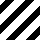
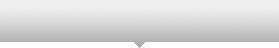
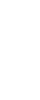
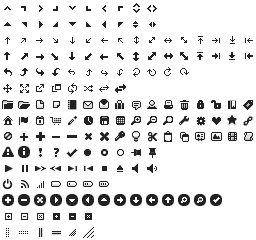
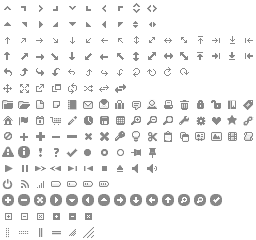
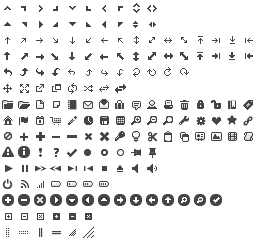
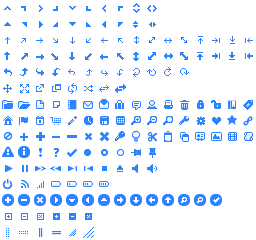
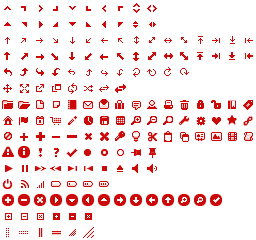
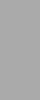
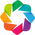
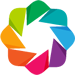
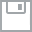
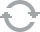
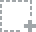
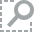
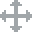
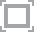
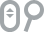

In [46]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import seaborn as sns
output_notebook()

'''
Scatter plot using bokeh library
Adapted from: http://aylien.com/web-summit-2015-tweets-part1

@param df - DataFrame with columns x and y
@param labels - list of labels for each point
@param categories - list of categories for each point (category assignments)
@param title - title for the plot
@param categories_to_show - list of categories to use for colour-coding. 
                            All other categories will be labelled "Other"
@param point_label - common prefix string for the tooltip label for all points
@param static_label - whether to annotate the points statically (not on mouseover)

'''
def plot_2d_scatter_bokeh(df, labels, categories, title, categories_to_show = None, point_label="movie", static_label=False):
    bplot = bp.figure(plot_width=800, plot_height=600, title=title,
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)

    color_assignment = []

    if(categories is not None):
        if(categories_to_show is None):
            categories_to_show = list(set(categories))

        pal = sns.color_palette('bright', len(categories_to_show))
        color_list = pal.as_hex()

        for i in range(0, len(categories)):
            try:
                cat_index = categories_to_show.index(list(categories)[i])
            except:
                # Assuming the default category named "Other"
                cat_index = categories_to_show.index("Other")

            color_assignment.append((color_list[cat_index]))
    else:
        categories = [] # Change to empty list
        
    bplot.scatter(x = df.x, y = df.y,
                        color = color_assignment,
                        source = bp.ColumnDataSource({"label": labels,
                                                      "category": categories}))
    if(static_label):
        bplot.text(x = df.x, y = df.y,
                    text=labels, text_color="#333333",
                    text_align="center", text_font_size="10pt")
    
    hover = bplot.select(dict(type = HoverTool))
    hover.tooltips = {"%s" % point_label: "@label - @category"}
    
    show(bplot)

## Wikipedia Plots
<hr>

### doc2vec processing

In [12]:
wiki_meta_df = pd.read_csv(dropbox_dir + 'wiki_meta_df.csv')

with open(dropbox_dir +'wiki_plots_d2v.pickle', 'rb') as f:
    wiki_plots = np.load(f)


In [15]:
def create_labelled_sent_list(plots):
    sents=[]
    for doc in plots:
        for sent in doc:
            sents.append(sent)
    return sents

all_sent = create_labelled_sent_list(wiki_plots)

In [16]:
%%time
cores = multiprocessing.cpu_count()
d2v_wiki = models.Doc2Vec(dm=1, dm_concat=1, size=100, window=20, negative=5, hs=0, min_count=2, workers=cores)
#d2v_wiki = models.Doc2Vec(dbow_words=1, size=100)
#d2v_wiki = models.Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores)
#d2v_wiki = models.Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
d2v_wiki.build_vocab(all_sent)
d2v_wiki.train(all_sent)

Wall time: 3min 4s


### Project the vectors down to 2-D and plot them

In [23]:
%%time

wiki_titles = list(set([s.tags[0] for s in all_sent]))
wiki_vectors = [d2v_wiki.docvecs[t] for t in wiki_titles]
wiki_titles = [unicode(s, 'utf-8') for s in wiki_titles]

countries = ['Other', 'Unknown', 'US', 'Germany', 'France', 'South_Korea', 'South Korea', 'Japan', 'China', 'China, Hong Kong', 'India', 'United Kingdom', 'United States']

wiki_meta_df.countries = wiki_meta_df.countries.fillna("Unknown")

# Contries corresponding to the movies in the dataframe, in the same order
country_vector_all = []
# Only the countries we want to show in the plots, with other countries marked as Others
country_vector_show = []

for t in wiki_titles:
    country = list(wiki_meta_df[wiki_meta_df.title == t.encode('utf8')].countries.values)[0]
    country_vector_all.append(country)
    if country in countries:
        country_vector_show.append(country)
    else:
        country_vector_show.append('Other') 

Wall time: 24.5 s


In [24]:
## Take a smaller subset of the data
wiki_vectors = wiki_vectors[:5000]
wiki_titles = wiki_titles[:5000]
country_vector_all = country_vector_all[:5000]
country_vector_show = country_vector_show[:5000]

In [25]:
wiki_d2v_pca = apply_pca(wiki_vectors)

#plot_2d_scatter(wiki_d2v_pca, wiki_titles, country_vector, "Wiki Plots - PCA")
plot_2d_scatter_bokeh(wiki_d2v_pca, wiki_titles, country_vector_show, "Wiki Plots - PCA")

In [26]:
%%time
wiki_d2v_tsne = apply_tsne(wiki_vectors)
#plot_2d_scatter(wiki_d2v_tsne, None, country_vector, "Wiki Plots - tSNE")
plot_2d_scatter_bokeh(wiki_d2v_tsne, wiki_titles, country_vector_show, "Wiki Plots - tSNE")

Wall time: 4min 24s


## Country similarities

In [35]:
country_vec_df = pd.DataFrame({'country':country_vector_all, 'plot_vector':wiki_vectors})

In [42]:
# Select the countries with significant number of movies
movie_counts = country_vec_df.groupby('country').apply(len)
countries_to_show = list(movie_counts[movie_counts > 35].index)
countries_to_show.remove('Unknown')    

In [43]:
def calculate_centroid(row):
    if(row.country.values[0] in countries_to_show):
        return np.mean(row.plot_vector)
    else:
        return None

country_centroids = country_vec_df.groupby('country').apply(calculate_centroid)
country_centroids = country_centroids.dropna()


In [50]:
vectors_2d = apply_isomap(list(country_centroids))
#plot_2d_scatter(vectors_2d, country_centroids.index, None, "Movie plot similarity across countries")
plot_2d_scatter_bokeh(vectors_2d, country_centroids.index, None, "Wiki Plots - MDS", static_label=True)

## IMDB Plots

<hr>

In [29]:
%%time
imdbdf = get_imdb_plots(2015)
plots = imdbdf[['title','plots']].apply(process_d2v_imdb, axis=1)
# filter out very short plot summaries
mask = plots.apply(lambda plot: sum([len(sent.words) for sent in plot]) > 50)
long_plots = plots[mask]

Wall time: 41.5 s


In [41]:
cores = multiprocessing.cpu_count()
#d2v = models.Doc2Vec(dm=1, dm_concat=1, size=50, window=10, negative=5, hs=0, min_count=2, workers=cores)
d2v = models.Doc2Vec(dbow_words=1, size=50)
#Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores)
#Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
all_sent = create_labelled_sent_list(plots)
long_plots_sent = create_labelled_sent_list(long_plots)
d2v.build_vocab(all_sent)
d2v.train(long_plots_sent)

521620

In [42]:

imdb_titles = list(set([s.tags[0] for s in long_plots_sent]))
imdb_vectors = [d2v.docvecs[t] for t in imdb_titles]

Wall time: 120 ms


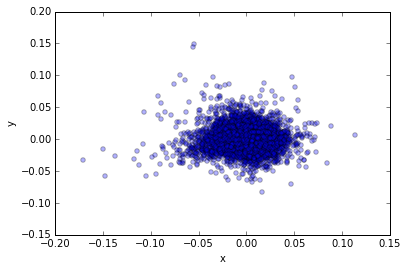

In [48]:
%%time
imdb_d2v_pca = apply_pca(imdb_vectors)
imdb_d2v_pca.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 6min 43s


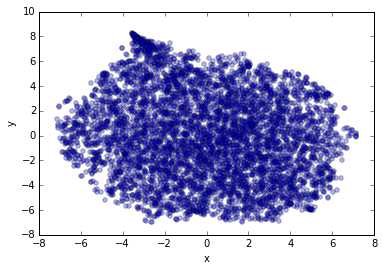

In [49]:
%%time
imdb_d2v_tsne = apply_tsne(imdb_vectors)
imdb_d2v_tsne.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 3min 12s


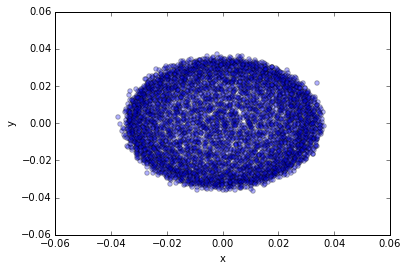

In [65]:
%%time
imdb_d2v_mds = apply_mds(imdb_vectors)
imdb_d2v_mds.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 17 s


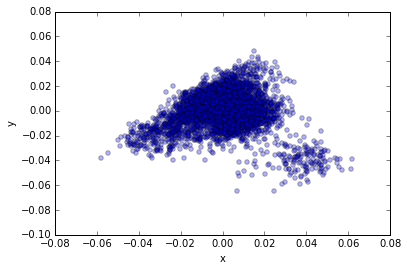

In [64]:
%%time
imdb_d2v_isomap = apply_isomap(imdb_vectors)
imdb_d2v_isomap.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)